                     st_tr_cost  dy_tr_cost
daytime                                    
2022-01-11 03:30:00        0.00       0.000
2022-01-11 04:30:00       58.92       0.000
2022-01-11 05:30:00       58.35       0.000
2022-01-11 06:30:00       59.34       0.000
2022-01-11 07:30:00       58.71       0.000
2022-01-11 08:30:00       57.81       0.000
2022-01-11 09:30:00       43.56      15.053
2022-01-11 10:30:00       56.70       0.000
2022-01-11 11:30:00       58.14       7.397
2022-01-11 12:30:00       59.91       0.000
2022-01-11 13:30:00       62.70       0.000
2022-01-11 14:30:00       60.03       0.000
2022-01-11 15:30:00       56.70       0.000
2022-01-11 16:30:00       57.81       0.000
2022-01-11 17:30:00       60.24       0.000
2022-01-11 18:30:00       59.13       0.000
2022-01-11 19:30:00       59.61       0.000
2022-01-11 20:30:00       58.29       0.000
2022-01-11 21:30:00       58.26      38.163
2022-01-11 22:30:00       62.16       0.000
2022-01-11 23:30:00       59.55 

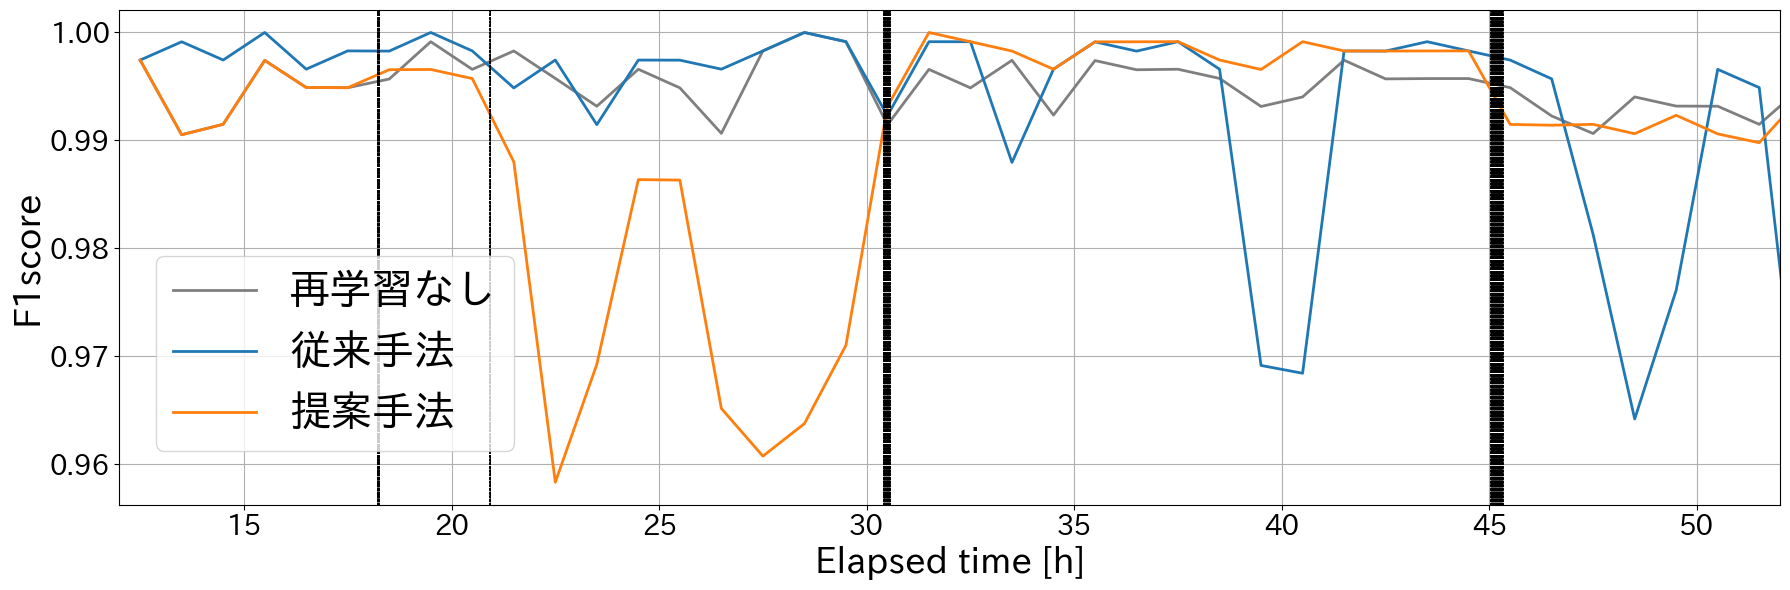

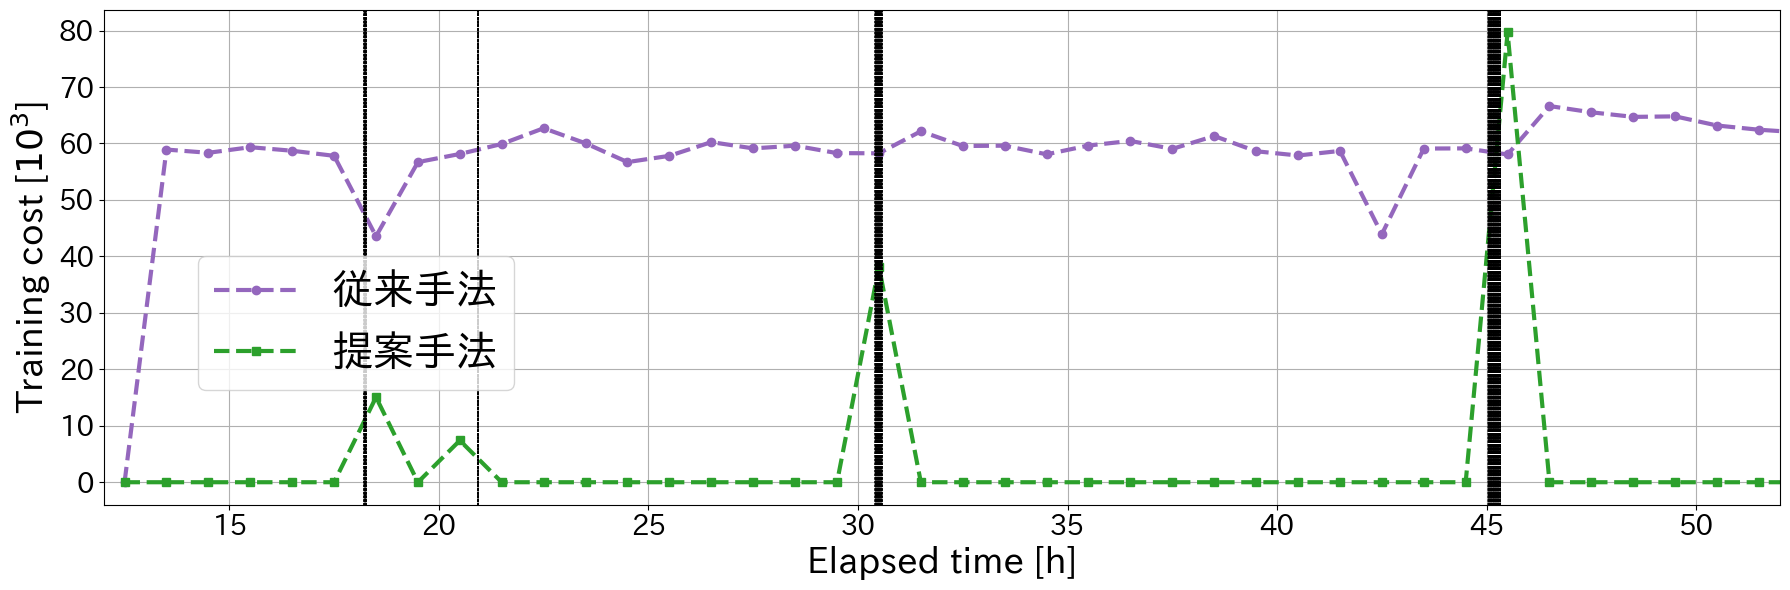

/mnt/nas0/g005/murasemaru/exp/3_Eval/20220110-20220114_UsEast/dy/dnn/euc_k8/c600/p3600/th0.025/res_img/eval_TN_rate.png
/mnt/nas0/g005/murasemaru/exp/3_Eval/20220110-20220114_UsEast/dy/dnn/euc_k8/c600/p3600/th0.025/res_img/eval_cost.png


In [8]:
import os
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
from datetime import timedelta,datetime

#-------------------------------------------------------------------#
# 定数定義
metrix = "F1_score"
nt_dir_path = "/mnt/nas0/g005/murasemaru/exp/MTG_20250722/nt"
st_dir_path = "/mnt/nas0/g005/murasemaru/exp/MTG_20250722/st"
st_epochs = 30
dy_dir_path = "/mnt/nas0/g005/murasemaru/exp/MTG_20250722/dy_old"
dy_epochs = 1
start_date = '2022-01-10 15:00:00'
#-------------------------------------------------------------------#

# 出力先ディレクトリの設定
output_dir = f"{dy_dir_path}/res_img"
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/eval_{metrix}.png"
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')

# 評価データの読み込みと前処理
nt_eval_data = pd.read_csv(f"{nt_dir_path}/eval_res.csv").rename(columns={metrix: "nt"})
st_eval_data = pd.read_csv(f"{st_dir_path}/eval_res.csv").rename(columns={metrix: "static"})
dy_eval_data = pd.read_csv(f"{dy_dir_path}/eval_res.csv").rename(columns={metrix: "dynamic"})

eval_data = pd.concat(
    [nt_eval_data.loc[:, ["daytime", "nt"]],
     st_eval_data.loc[:, ["static"]],
     dy_eval_data.loc[:, ["dynamic"]]],
    axis=1
)
eval_data['daytime'] = pd.to_datetime(eval_data['daytime'])

# 訓練データの読み込みと前処理
st_tr_data = pd.read_csv(f"{st_dir_path}/tr_res.csv")
st_tr_data["daytime"] = pd.to_datetime(st_tr_data["daytime"])
dy_tr_data = pd.read_csv(f"{dy_dir_path}/tr_res.csv")
dy_tr_data["daytime"] = pd.to_datetime(dy_tr_data["daytime"])

# 学習コストを計算する関数を定義
def calculate_training_cost(tr_data, eval_times, epochs, name, window_minutes=60):
    costs = []
    for eval_time in eval_times:
        start_time = eval_time
        end_time = eval_time + pd.Timedelta(minutes=window_minutes)
        window_data = tr_data[(tr_data["daytime"] >= start_time) & (tr_data["daytime"] < end_time)]
        if window_data.empty:
            costs.append(0)
        else:
            tr_cost = window_data["flow_num"] * epochs
            costs.append(tr_cost.sum())
    return pd.Series(costs, index=eval_times+timedelta(minutes=30), name=name)

# 評価時刻のリスト
eval_start_times = eval_data['daytime']
eval_start_times = eval_start_times - timedelta(minutes=30)

# 各データセットの学習コストを計算
st_tr_cost = calculate_training_cost(st_tr_data, eval_start_times, st_epochs, "st_tr_cost") / 1e3  # 10^6で割る
dy_tr_cost = calculate_training_cost(dy_tr_data, eval_start_times, dy_epochs, "dy_tr_cost") / 1e3  # 10^6で割る
tr_cost = pd.merge(st_tr_cost,dy_tr_cost,how='inner', left_index=True, right_index=True)
print(tr_cost)

# データの結合
print(eval_data)

#-------------------------------------------------------------------#
# 経過時間の計算（時間単位）
# offset_hours = 12  # 表示調整のためのオフセット
eval_data['elapsed_hours'] = (eval_data['daytime'] - start_date).dt.total_seconds() / 3600
tr_cost = tr_cost.reset_index()
tr_cost['elapsed_hours'] = (tr_cost['daytime'] - start_date).dt.total_seconds() / 3600

# dy_tr_data の日時を破線でグラフに追加するための処理
dy_training_times = dy_tr_data["daytime"]

def plot_training_cost(tr_cost, start_date, output_path, label_size, ticks_size, legend_size, dy_training_times):
    
    fig, ax = plt.subplots(figsize=(18, 6))
    # 学習コストをプロット
    line1, = ax.plot(tr_cost['elapsed_hours'], tr_cost['st_tr_cost'], label='従来手法',
                     linewidth=3, linestyle='--', color='tab:purple', marker='o')
    line2, = ax.plot(tr_cost['elapsed_hours'], tr_cost['dy_tr_cost'], label='提案手法',
                     linewidth=3, linestyle='--', color='tab:green', marker='s')
    ax.set_ylabel(r'Training cost [$10^3$]', fontsize=label_size, color='black')
    ax.set_xlabel('Elapsed time [h]', fontsize=label_size, color='black')
    
    # dy_training_times を縦線として描画
    for time in dy_training_times:
        elapsed_hour = (time - start_date).total_seconds() / 3600
        # + offset_hours
        ax.axvline(x=elapsed_hour, color='black',alpha=0.8, linestyle='--', linewidth=0.5, label="Dynamic Training Time")

    # 目盛りを調整（ここで目盛り間隔を指定）
    ax.yaxis.set_major_locator(MultipleLocator(10))  # 目盛り間隔を10に設定
    ax.tick_params(axis='y', labelsize=ticks_size)
    ax.tick_params(axis='x', labelsize=ticks_size)
    ax.grid(True)

    # 凡例
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    
    plt.xlim(12, 52)  # 描画範囲を固定
    fig.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.3, 0.6), fontsize=legend_size)

    # 保存と表示
    fig.tight_layout()
    plt.savefig(output_path, dpi=500)
    plt.show()

def plot_metrix(eval_data, start_date, output_path, label_size, ticks_size, legend_size, dy_training_times):
    
    fig, ax = plt.subplots(figsize=(18, 6))
    # F1スコアをプロット
    line1, = ax.plot(eval_data['elapsed_hours'], eval_data["nt"], label="再学習なし", linewidth=2, color="tab:gray")
    line2, = ax.plot(eval_data['elapsed_hours'], eval_data["static"], label="従来手法", linewidth=2, color="tab:blue")
    line3, = ax.plot(eval_data['elapsed_hours'], eval_data["dynamic"], label="提案手法", linewidth=2, color='tab:orange')
    ax.set_ylabel('F1score', fontsize=label_size, color='black')
    ax.set_xlabel('Elapsed time [h]', fontsize=label_size, color='black')
    
    # dy_training_times を縦線として描画
    for time in dy_training_times:
        elapsed_hour = (time - start_date).total_seconds() / 3600
        # + offset_hours
        ax.axvline(x=elapsed_hour, color='black',alpha=0.8, linestyle='--', linewidth=0.5, label="Dynamic Training Time")

    ax.tick_params(axis='y', labelsize=ticks_size)
    ax.tick_params(axis='x', labelsize=ticks_size)
    ax.grid(True)

    # 凡例
    lines = [line1, line2, line3]
    labels = [line.get_label() for line in lines]
    plt.xlim(12, 52)  # 描画範囲を固定
    fig.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.3, 0.6), fontsize=legend_size)

    # 保存と表示
    fig.tight_layout()
    plt.savefig(output_path, dpi=500)
    plt.show()

# ファイル出力パスの設定
output_path_cost = f"{output_dir}/eval_cost.png"

# 修正後のプロット実行
plot_metrix(eval_data, start_date, output_path, label_size=26, ticks_size=20, legend_size=30, dy_training_times=dy_training_times)
plot_training_cost(tr_cost, start_date, output_path_cost, label_size=26, ticks_size=20, legend_size=30, dy_training_times=dy_training_times)

print(output_path)
print(output_path_cost)

